In [ ]:
import json
import re
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import userdata

import tensorflow.keras
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

_KERAS_BACKEND = tensorflow.keras.backend
_KERAS_LAYERS = tensorflow.keras.layers
_KERAS_MODELS = tensorflow.keras.models
_KERAS_UTILS = tensorflow.keras.utils

BASE_WEIGHTS_URL = 'https://github.com/keras-team/keras-applications/releases/download/densenet/'
DENSENET121_WEIGHTS_URL = BASE_WEIGHTS_URL + 'densenet121_weights_tf_dim_ordering_tf_kernels.h5'
DENSENET121_WEIGHTS_URL_NOTOP = BASE_WEIGHTS_URL + 'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'

## Dataset preparation

### Kaggle configuration

In order to use Kaggle's command line tool to download the dataset, we first setup some configuration file with our crendentials, which is stored in notebook's secret environment variables.

In [ ]:
# creates a kaggle directory in the user's home directory
kaggle_root = Path('/root/.kaggle')
if not kaggle_root.exists():
  kaggle_root.mkdir()
# creates a kaggle.json file in the kaggle directory with the user's kaggle credentials
kaggle_json = kaggle_root / 'kaggle.json'
if not kaggle_json.exists():
  kaggle_json.write_text(json.dumps({
    'username': userdata.get('kaggle_username'),
    'key': userdata.get('kaggle_key'),
  }))

# sets the permissions of the kaggle.json file to 600
kaggle_json.chmod(0o600)

### Dataset download

It will take about 5 minutes to download the 9.58GB dataset. After downloading the dataset, we make appropriate directories and unzip dataset accordingly.

In [ ]:
# downloads the dataset
!kaggle datasets download 'nikhilpandey360/chest-xray-masks-and-labels'

# make appropriate directories for storing the dataset
%mkdir dataset
%mkdir dataset/temp
%mkdir dataset/images
%mkdir dataset/images_no_mask
%mkdir dataset/masks
%mkdir dataset/masks_binary
%mkdir dataset/test
%mkdir dataset/readings

# maps directories to python Paths
dataset_root = Path('dataset')
temp_path = dataset_root / 'temp'
images_path = dataset_root / 'images'
no_mask_images_path = dataset_root / 'images_no_mask'
masks_path = dataset_root / 'masks'
binary_masks_path = dataset_root / 'masks_binary'
test_path = dataset_root / 'test'
readings_path = dataset_root / 'readings'

# unzips the dataset
if not list(temp_path.glob('*')):
  !unzip chest-xray-masks-and-labels.zip -d dataset/temp/
  %mv dataset/temp/Lung\ Segmentation/CXR_png/* dataset/images/
  %mv dataset/temp/Lung\ Segmentation/masks/* dataset/masks/
  %mv dataset/temp/Lung\ Segmentation/test/* dataset/test/
  %mv dataset/temp/Lung\ Segmentation/ClinicalReadings/* dataset/readings

### Dataset cleaning

In [ ]:
def parse_reading(reading_path: Path):
  if reading_path.stem.startswith('CHNCXR'):
    return parse_chncxr(reading_path)
  elif reading_path.stem.startswith('MCUCXR'):
    return parse_mcucxr(reading_path)
  else:
    raise ValueError(f'Unknown reading file: {reading_path.stem}')


def parse_chncxr(reading_path: Path):
  lines = reading_path.read_text().splitlines()
  lines = [line.strip() for line in lines if line.strip()]

  state = int(reading_path.stem.split('_')[-1])

  line0 = lines[0].lower().strip()
  line0 = re.sub(r',', ' ', line0)
  line0 = re.sub(r'\s+', ' ', line0)
  line0 = re.sub(r'femal\s+', 'female ', line0)

  if line0.startswith('male'):
    sex = 'M'
  else:
    sex = 'F'

  if 'month' in line0:
    age = int(re.search(r'\d+', line0).group())
    age //= 12
  else:
    age = int(re.search(r'\d+', line0).group())

  description = ' '.join(lines[1:])
  description = description.replace('normale', 'normal')
  return sex, age, state, description


def parse_mcucxr(reading_path: Path):
  lines = reading_path.read_text().splitlines()
  lines = [line.strip() for line in lines if line.strip()]

  state = int(reading_path.stem.split('_')[-1])

  sex = lines[0].lower().split(':')[-1].strip().upper()
  if sex not in ['M', 'F']:
    return None

  age = lines[1].lower().split(':')[-1].strip()
  age = int(re.search(r'\d+', age).group())

  description = ' '.join(lines[2:])
  return sex, age, state, description

In [ ]:
# some mask files do not end with '_mask'
# renames all the mask files to end with '_mask'
masks = sorted(list(masks_path.glob('*.png')))
for mask in masks:
  stem = mask.stem
  if stem.endswith('_mask'):
    mask.rename(mask.with_stem(stem[:-5]))

In [ ]:
# some mask files are not binary (multiple channels or values)
# converts all the mask files to binary
masks = sorted(list(masks_path.glob('*.png')))
for mask in masks:
  binary_mask_path = binary_masks_path / mask.name
  if binary_mask_path.exists():
    continue
  img = cv2.imread(str(mask), cv2.IMREAD_GRAYSCALE)
  _, binary_mask = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)
  cv2.imwrite(str(binary_mask_path), binary_mask)

In [ ]:
# some images do not have a mask
# moves all the images without a mask to a separate folder and not use them
images = sorted(list(images_path.glob('*.png')))
for image in images:
  image_name = image.stem
  mask = binary_masks_path / (image_name + '.png')
  if not mask.exists():
    image.rename(no_mask_images_path / image.name)

In [ ]:
# loads the dataset
dataset = []
images = sorted(list(images_path.glob('*.png')))
for image in images:
    image_name = image.stem
    mask = binary_masks_path / (image_name + '.png')
    reading = readings_path / (image_name + '.txt')
    metadata = parse_reading(reading)
    if metadata is None:
        continue
    sex, age, state, description = metadata
    dataset.append({
        'image': str(image),
        'mask': str(mask),
        'sex': sex,
        'age': age,
        'state': str(state),
        'description': description,
    })

### Dataset preview

In [ ]:
df = pd.DataFrame(dataset)
df

,image,mask,sex,age,state,description
0,dataset/images/CHNCXR_0001_0.png,dataset/masks_binary/CHNCXR_0001_0.png,M,45,0,normal
1,dataset/images/CHNCXR_0002_0.png,dataset/masks_binary/CHNCXR_0002_0.png,M,63,0,normal
2,dataset/images/CHNCXR_0003_0.png,dataset/masks_binary/CHNCXR_0003_0.png,F,48,0,normal
3,dataset/images/CHNCXR_0004_0.png,dataset/masks_binary/CHNCXR_0004_0.png,M,58,0,normal
4,dataset/images/CHNCXR_0005_0.png,dataset/masks_binary/CHNCXR_0005_0.png,M,28,0,normal
...,...,...,...,...,...,...
698,dataset/images/MCUCXR_0383_1.png,dataset/masks_binary/MCUCXR_0383_1.png,F,14,1,calcified granuloma LUL behind 4th rib anterior
699,dataset/images/MCUCXR_0387_1.png,dataset/masks_binary/MCUCXR_0387_1.png,M,42,1,inactive scars RUL
700,dataset/images/MCUCXR_0390_1.png,dataset/masks_binary/MCUCXR_0390_1.png,M,52,1,Rt apical scarring. LUL scars and some infiltr...
701,dataset/images/MCUCXR_0393_1.png,dataset/masks_binary/MCUCXR_0393_1.png,F,30,1,left pleural effusion; best seen on lateral vi...


In [ ]:
def display_image(idx):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  image = cv2.imread(str(df['image'][idx]), cv2.IMREAD_GRAYSCALE)
  axes[0].imshow(image, cmap='gray')
  axes[0].set_title(f'image')
  axes[0].axis('off')

  mask = cv2.imread(str(df['mask'][idx]), cv2.IMREAD_GRAYSCALE)
  axes[1].imshow(mask, cmap='gray')
  axes[1].set_title(f'mask')
  axes[1].axis('off')

  mask = np.ones_like(image) * 255 * mask
  overlay = cv2.addWeighted(image, 0.5, mask, 0.5, 0)
  axes[2].imshow(overlay, cmap='gray')
  axes[2].set_title(f'overlay')
  axes[2].axis('off')

  image_name = df['image'][idx].stem
  image_state = {0: 'negative', 1: 'positive'}[df['state'][idx]]
  fig.suptitle(f'{image_name} ({image_state})')
  plt.show()

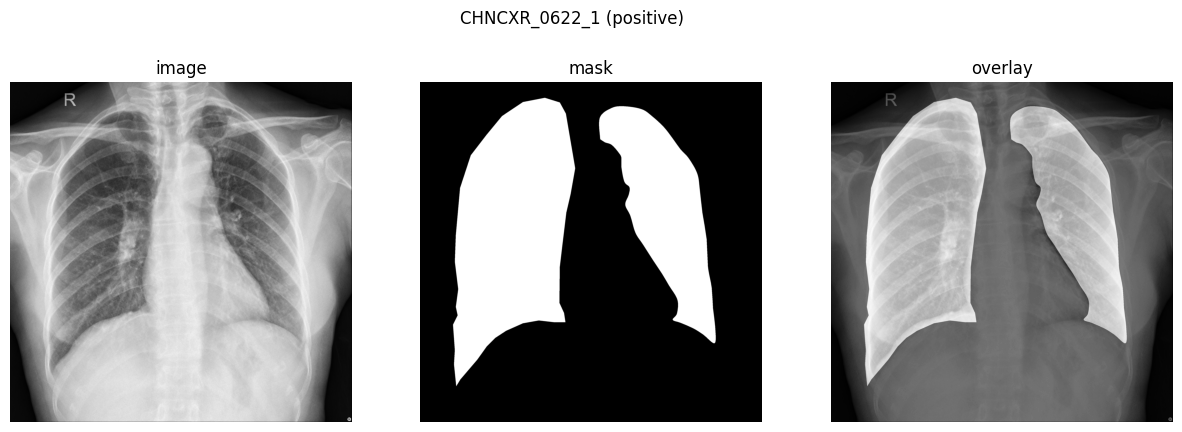

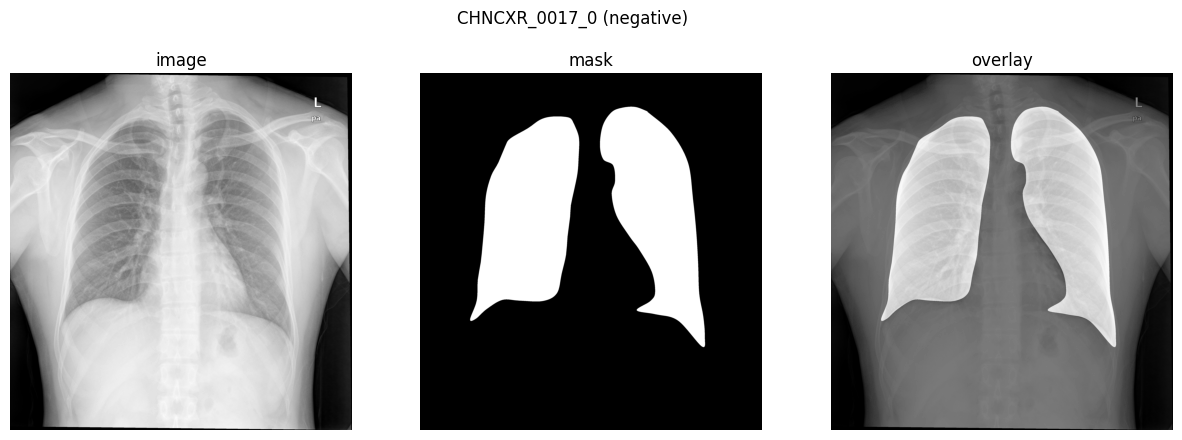

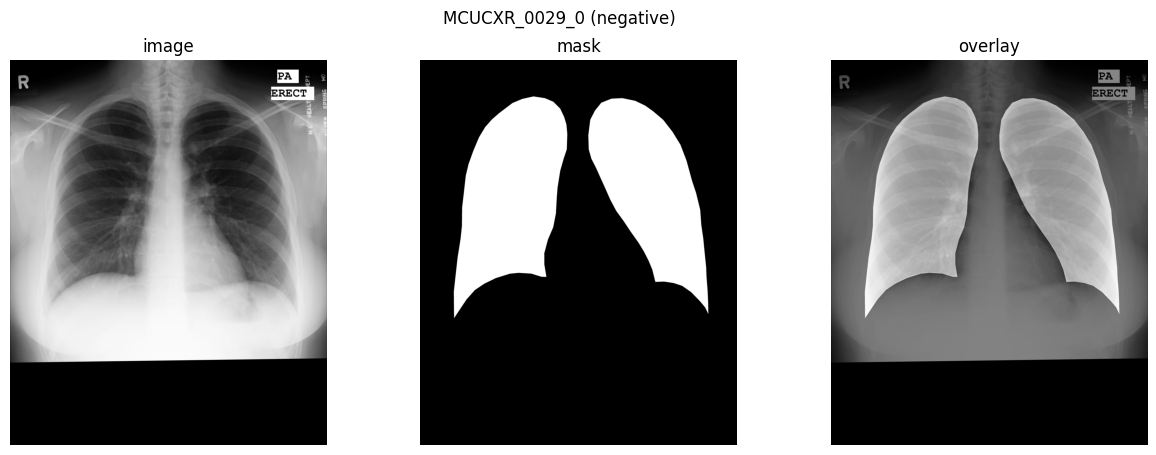

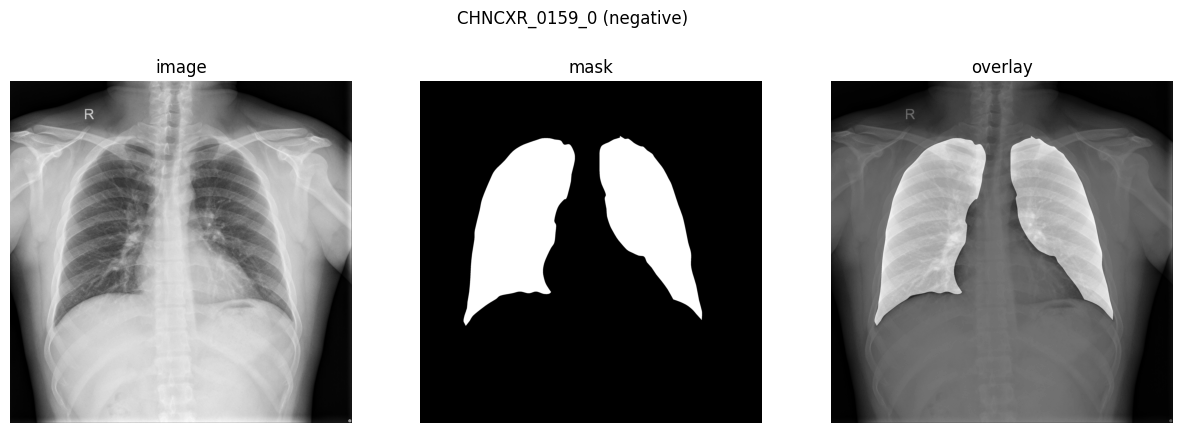

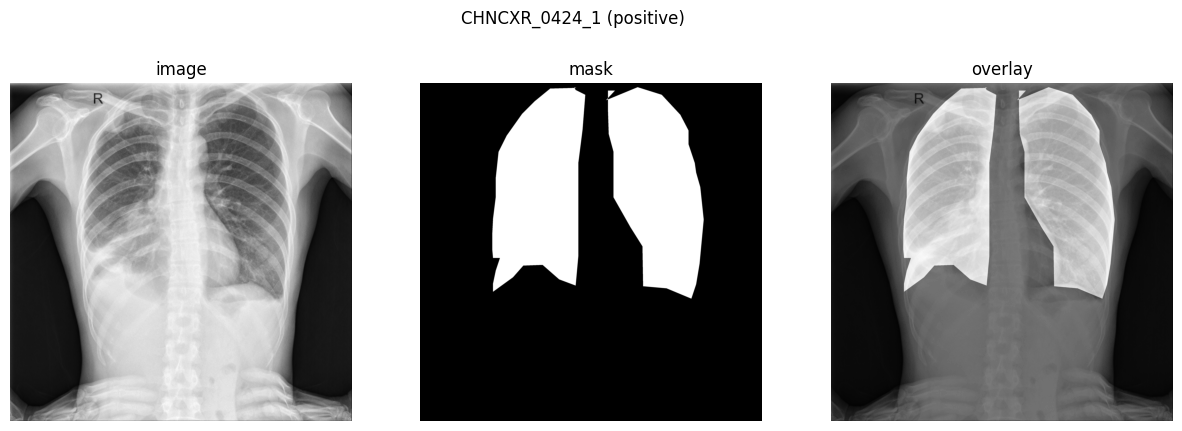

In [ ]:
for _ in range(5):
  idx = np.random.randint(len(df))
  display_image(idx)

## Model training

In [ ]:
auto_target_size = (128, 128)
auto_batch_size = 32
seed = 42

nn_datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.1,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)

nn_train_generator = nn_datagen.flow_from_dataframe(
    dataframe=df,
    subset='training',
    x_col='image',
    y_col='state',
    batch_size=auto_batch_size,
    seed=seed,
    shuffle=True,
    class_mode='categorical',
    target_size=auto_target_size,
    color_mode='rgb')

nn_valid_generator = nn_datagen.flow_from_dataframe(
    dataframe=df,
    subset='validation',
    x_col='image',
    y_col='state',
    batch_size=auto_batch_size,
    seed=seed,
    shuffle=True,
    class_mode='categorical',
    target_size=auto_target_size,
    color_mode='rgb')

for image_batch, label_batch in nn_valid_generator:
    print('Image batch shape: ', image_batch.shape)
    print('Label batch shape: ', label_batch.shape)
    break

nn_test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2)

nn_validation_test_generator = nn_test_datagen.flow_from_dataframe(
    dataframe=df,
    subset='validation',
    x_col='image',
    y_col='state',
    batch_size=auto_batch_size,
    seed=seed,
    shuffle=False,
    class_mode='categorical',
    target_size=auto_target_size,
    color_mode='rgb')

def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


def _obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate a model's input shape.
    # Arguments
        input_shape: Either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_size: Default input width/height for the model.
        min_size: Minimum input width/height accepted by the model.
        data_format: Image data format to use.
        require_flatten: Whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: One of `None` (random initialization)
            or 'imagenet' (pre-training on ImageNet).
            If weights='imagenet' input channels must be equal to 3.
    # Returns
        An integer shape tuple (may include None entries).
    # Raises
        ValueError: In case of invalid argument values.
    """
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                print('This model usually expects 1 or 3 input channels. '
                      'However, it was passed an input_shape with ' +
                      str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                print('This model usually expects 1 or 3 input channels. '
                      'However, it was passed an input_shape with ' +
                      str(input_shape[-1]) + ' input channels.')
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting `include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                        (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                        (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape


def dense_block(x, blocks, name):
    """A dense block.
    # Arguments
        x: input tensor.
        blocks: integer, the number of building blocks.
        name: string, block label.
    # Returns
        output tensor for the block.
    """
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x


def transition_block(x, reduction, name):
    """A transition block.
    # Arguments
        x: input tensor.
        reduction: float, compression rate at transition layers.
        name: string, block label.
    # Returns
        output tensor for the block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_bn')(x)
    x = layers.Activation('relu', name=name + '_relu')(x)
    x = layers.Conv2D(int(backend.int_shape(x)[bn_axis] * reduction), 1,
                      use_bias=False,
                      name=name + '_conv')(x)
    x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x


def conv_block(x, growth_rate, name):
    """A building block for a dense block.
    # Arguments
        x: input tensor.
        growth_rate: float, growth rate at dense layers.
        name: string, block label.
    # Returns
        Output tensor for the block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    x1 = layers.BatchNormalization(axis=bn_axis,
                                   epsilon=1.001e-5,
                                   name=name + '_0_bn')(x)
    x1 = layers.Activation('relu', name=name + '_0_relu')(x1)
    x1 = layers.Conv2D(4 * growth_rate, 1,
                       use_bias=False,
                       name=name + '_1_conv')(x1)
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                   name=name + '_1_bn')(x1)
    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = layers.Conv2D(growth_rate, 3,
                       padding='same',
                       use_bias=False,
                       name=name + '_2_conv')(x1)
    x = layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x


def DenseNet(blocks,
             include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=False, name='conv1-conv')(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name='conv1-bn')(x)
    x = layers.Activation('relu', name='conv1-relu')(x)
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1')(x)

    x = dense_block(x, blocks[0], name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, blocks[1], name='conv3')
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, blocks[2], name='conv4')
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, blocks[3], name='conv5')

    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = layers.Activation('relu', name='relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    if blocks == [6, 12, 24, 16]:
        model = models.Model(inputs, x, name='densenet121')
    elif blocks == [6, 12, 32, 32]:
        model = models.Model(inputs, x, name='densenet169')
    elif blocks == [6, 12, 48, 32]:
        model = models.Model(inputs, x, name='densenet201')
    else:
        model = models.Model(inputs, x, name='densenet')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            if blocks == [6, 12, 24, 16]:
                weights_path = keras_utils.get_file(
                    'densenet121_weights_tf_dim_ordering_tf_kernels.h5',
                    DENSENET121_WEIGHTS_URL,
                    cache_subdir='models',
                    file_hash='9d60b8095a5708f2dcce2bca79d332c7')
            elif blocks == [6, 12, 32, 32]:
                weights_path = keras_utils.get_file(
                    'densenet169_weights_tf_dim_ordering_tf_kernels.h5',
                    DENSENET169_WEIGHTS_URL,
                    cache_subdir='models',
                    file_hash='d699b8f76981ab1b30698df4c175e90b')
            elif blocks == [6, 12, 48, 32]:
                weights_path = keras_utils.get_file(
                    'densenet201_weights_tf_dim_ordering_tf_kernels.h5',
                    DENSENET201_WEIGHTS_URL,
                    cache_subdir='models',
                    file_hash='1ceb130c1ea1b78c3bf6114dbdfd8807')
        else:
            if blocks == [6, 12, 24, 16]:
                weights_path = keras_utils.get_file(
                    'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    DENSENET121_WEIGHTS_URL_NOTOP,
                    cache_subdir='models',
                    file_hash='30ee3e1110167f948a6b9946edeeb738')
            elif blocks == [6, 12, 32, 32]:
                weights_path = keras_utils.get_file(
                    'densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    DENSENET169_WEIGHTS_URL_NOTOP,
                    cache_subdir='models',
                    file_hash='b8c4d4c20dd625c148057b9ff1c1176b')
            elif blocks == [6, 12, 48, 32]:
                weights_path = keras_utils.get_file(
                    'densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    DENSENET201_WEIGHTS_URL_NOTOP,
                    cache_subdir='models',
                    file_hash='c13680b51ded0fb44dff2d8f86ac8bb1')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


def DenseNet121(include_top=True, weights='imagenet',
                input_tensor=None, input_shape=None, pooling=None, classes=1000, **kwargs):
    return DenseNet([6, 12, 24, 16], include_top, weights, input_tensor, input_shape, pooling, classes, **kwargs)


def preprocess_input(x, data_format=None, **kwargs):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 3D or 4D numpy array consists of RGB values within [0, 255].
        data_format: data format of the image tensor.
    # Returns
        Preprocessed array.
    """
    return imagenet_utils.preprocess_input(x, data_format, mode='torch', **kwargs)


densenet121_model = DenseNet121(include_top=False, weights='imagenet',
                                input_tensor=None, input_shape=(128, 128, 3), pooling=max)

# Create model for labelling images.
# act = 'relu'
act = tensorflow.keras.layers.LeakyReLU(alpha=0.3)
out = densenet121_model.output
out = Flatten()(out)
out = Dense(64, activation=act, name='dense1')(out)
out = Dropout(0.2)(out)
out = Dense(64, activation=act, name='dense2')(out)
out = Dropout(0.2)(out)
out = Dense(32, activation=act, name='dense3')(out)
out = Dropout(0.2)(out)
out = Dense(16, activation=act, name='dense4')(out)
out = Dense(2, activation='softmax')(out)
labeller = Model(densenet121_model.input, out)
# print(labeller.summary())

optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001)
labeller.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
nb_epoch = 30
NN_STEP_SIZE_TRAIN = np.ceil(nn_train_generator.samples / nn_train_generator.batch_size)
NN_STEP_SIZE_VALID = np.ceil(nn_valid_generator.samples / nn_valid_generator.batch_size)

# print(NN_STEP_SIZE_TRAIN, NN_STEP_SIZE_VALID)
# print(nn_train_generator.samples, nn_valid_generator.samples)
# print(nn_train_generator.batch_size, nn_valid_generator.batch_size)

# Callbacks.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.4, min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                   filepath='labeller_model' + '.weights.h5',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   mode='min')

nn_train_generator.reset()
nn_valid_generator.reset()

Found 563 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.
Image batch shape:  (32, 128, 128, 3)
Label batch shape:  (32, 2)
Found 140 validated image filenames belonging to 2 classes.


In [ ]:
history = labeller.fit_generator(
  generator=nn_train_generator,-
  steps_per_epoch=NN_STEP_SIZE_TRAIN,
  validation_data=nn_valid_generator,
  validation_steps=NN_STEP_SIZE_VALID,
  epochs=nb_epoch,
  callbacks=[learning_rate_reduction, early_stopping, model_checkpoint])

<ipython-input-20-8a92a6b62e26>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = labeller.fit_generator(


Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.7128 - accuracy: 0.5933

18/18 [==============================] - 162s 6s/step - loss: 0.7128 - accuracy: 0.5933 - val_loss: 0.7932 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.6821

18/18 [==============================] - 92s 5s/step - loss: 0.6047 - accuracy: 0.6821 - val_loss: 0.5908 - val_accuracy: 0.8929 - lr: 1.0000e-04
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.5449 - accuracy: 0.7158

18/18 [==============================] - 92s 5s/step - loss: 0.5449 - accuracy: 0.7158 - val_loss: 0.3982 - val_accuracy: 0.9857 - lr: 1.0000e-04
Epoch 4/30
18/18 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.7673

18/18 [==============================] - 85s 5s/step - loss: 0.5203 - accuracy: 0.7673 - val_loss: 0.4786 - val_accuracy: 0.9286 - lr: 1.0000e-04
Epoch 5/30
18/18 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.7726

18/18 [==============================] - 87s 5s/step - loss: 0.4818 - accuracy: 0.7726 - val_loss: 0.3738 - val_accuracy: 0.9857 - lr: 1.0000e-04
Epoch 6/30
18/18 [==============================] - ETA: 0s - loss: 0.4375 - accuracy: 0.8171

18/18 [==============================] - 88s 5s/step - loss: 0.4375 - accuracy: 0.8171 - val_loss: 0.2463 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/30
18/18 [==============================] - ETA: 0s - loss: 0.4556 - accuracy: 0.8153

18/18 [==============================] - 85s 5s/step - loss: 0.4556 - accuracy: 0.8153 - val_loss: 0.3200 - val_accuracy: 0.9714 - lr: 1.0000e-04
Epoch 8/30
18/18 [==============================] - ETA: 0s - loss: 0.4283 - accuracy: 0.8099

18/18 [==============================] - 90s 5s/step - loss: 0.4283 - accuracy: 0.8099 - val_loss: 0.2355 - val_accuracy: 0.9857 - lr: 1.0000e-04
Epoch 9/30
18/18 [==============================] - ETA: 0s - loss: 0.3759 - accuracy: 0.8472

18/18 [==============================] - 87s 5s/step - loss: 0.3759 - accuracy: 0.8472 - val_loss: 0.1595 - val_accuracy: 0.9929 - lr: 1.0000e-04
Epoch 10/30
18/18 [==============================] - ETA: 0s - loss: 0.3781 - accuracy: 0.8437

18/18 [==============================] - 88s 5s/step - loss: 0.3781 - accuracy: 0.8437 - val_loss: 0.0839 - val_accuracy: 0.9929 - lr: 1.0000e-04
Epoch 11/30
18/18 [==============================] - ETA: 0s - loss: 0.4052 - accuracy: 0.8153

18/18 [==============================] - 93s 5s/step - loss: 0.4052 - accuracy: 0.8153 - val_loss: 0.0866 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 12/30
18/18 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.8313

18/18 [==============================] - 86s 5s/step - loss: 0.3996 - accuracy: 0.8313 - val_loss: 0.2345 - val_accuracy: 0.9643 - lr: 1.0000e-04
Epoch 13/30
18/18 [==============================] - ETA: 0s - loss: 0.3269 - accuracy: 0.8544

18/18 [==============================] - 86s 5s/step - loss: 0.3269 - accuracy: 0.8544 - val_loss: 0.4097 - val_accuracy: 0.8929 - lr: 1.0000e-04
Epoch 13: early stopping


In [ ]:
history

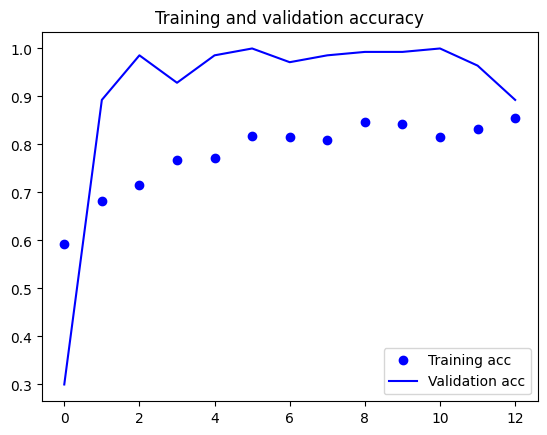

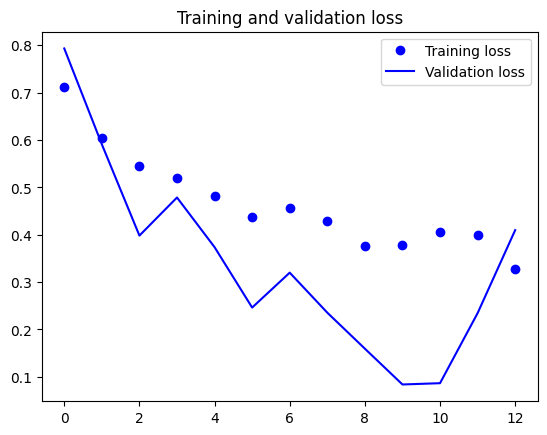

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
loaded_model = DenseNet121(include_top=False, weights='imagenet',
                           input_tensor=None, input_shape=(128, 128, 3), pooling=max)

act = tensorflow.keras.layers.LeakyReLU(alpha=0.3)
out = loaded_model.output
out = Flatten()(out)
out = Dense(64, activation=act, name='dense1')(out)
out = Dropout(0.2)(out)
out = Dense(64, activation=act, name='dense2')(out)
out = Dropout(0.2)(out)
out = Dense(32, activation=act, name='dense3')(out)
out = Dropout(0.2)(out)
out = Dense(16, activation=act, name='dense4')(out)
out = Dense(2, activation='softmax')(out)
loaded_model = Model(loaded_model.input, out)

In [ ]:
loaded_model.load_weights('labeller_model.weights.h5')
optimizer = tensorflow.keras.optimizers.RMSprop(lr=1e-4)
loaded_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
NN_STEP_SIZE_test = np.ceil(nn_validation_test_generator.samples / nn_validation_test_generator.batch_size)

nn_validation_test_generator.reset()
results_VALID_ds = loaded_model.evaluate_generator(nn_validation_test_generator, NN_STEP_SIZE_test, verbose=1)

<ipython-input-26-8b8f18982736>:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results_VALID_ds = loaded_model.evaluate_generator(nn_validation_test_generator, NN_STEP_SIZE_test, verbose=1)


5/5 [==============================] - 17s 2s/step - loss: 0.2109 - accuracy: 0.9286


In [ ]:
nn_validation_test_generator.reset()
validation_predictions = loaded_model.predict_generator(
    nn_validation_test_generator, NN_STEP_SIZE_VALID, workers=1, use_multiprocessing=False, verbose=1)

index_array_of_images = nn_validation_test_generator.index_array[:validation_predictions.shape[0]]

actual_labels = np.array(nn_validation_test_generator.classes)[index_array_of_images]
predicted_labels = np.argmax(validation_predictions[index_array_of_images], axis=1)

<ipython-input-27-945b203d10bc>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  validation_predictions = loaded_model.predict_generator(


5/5 [==============================] - 16s 2s/step


In [ ]:
actual_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
predicted_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print(predicted_labels.shape)
print(np.array(actual_labels).shape)
print("Total number of images classified correctly = ", np.sum(actual_labels == predicted_labels))
print("hence accuracy = ", np.sum(actual_labels == predicted_labels) / predicted_labels.shape)

Confusn_matrix_validation_set = confusion_matrix(actual_labels, predicted_labels)

print("prediction is done on ", np.sum(Confusn_matrix_validation_set), " number of examples\n")
print('Confusion Matrix')
print(Confusn_matrix_validation_set)

(140,)
(140,)
Total number of images classified correctly =  130
hence accuracy =  [0.92857143]
prediction is done on  140  number of examples

Confusion Matrix
[[130  10]
 [  0   0]]


<Axes: title={'center': 'Confusion Matrix'}>

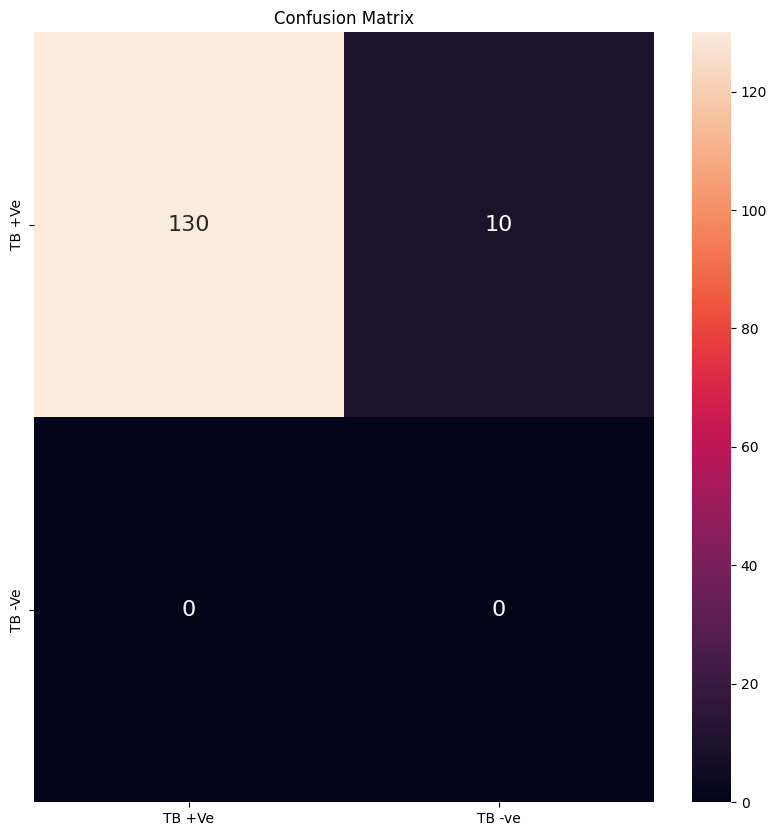

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("Confusion Matrix")
sns.heatmap(Confusn_matrix_validation_set, annot=True, fmt='g', annot_kws={"size": 16},
            xticklabels=['TB +Ve', 'TB -ve'], yticklabels=['TB +Ve', 'TB -Ve'])

In [ ]:
nn_validation_test_generator.reset()
nn_sample_image_batch = next(nn_validation_test_generator)

sample_predictions = loaded_model.predict(nn_sample_image_batch[0],batch_size=32, verbose=1)
sample_predicted_labels = np.argmax(sample_predictions, axis=1)
ground_truth_labels = nn_sample_image_batch[1]
ground_truth_labels = np.argmax(ground_truth_labels, axis=1)
np.sum(sample_predicted_labels == ground_truth_labels)
print("accurate predictions on sample batch: ", np.sum(sample_predicted_labels == ground_truth_labels) / 32)

1/1 [==============================] - 0s 51ms/step
accurate predictions on sample batch:  0.96875


In [ ]:
titles = []

for i in range(32):
  if sample_predicted_labels[i] == 0:
    titles.append('TB')
  else:
    titles.append('Not a TB')

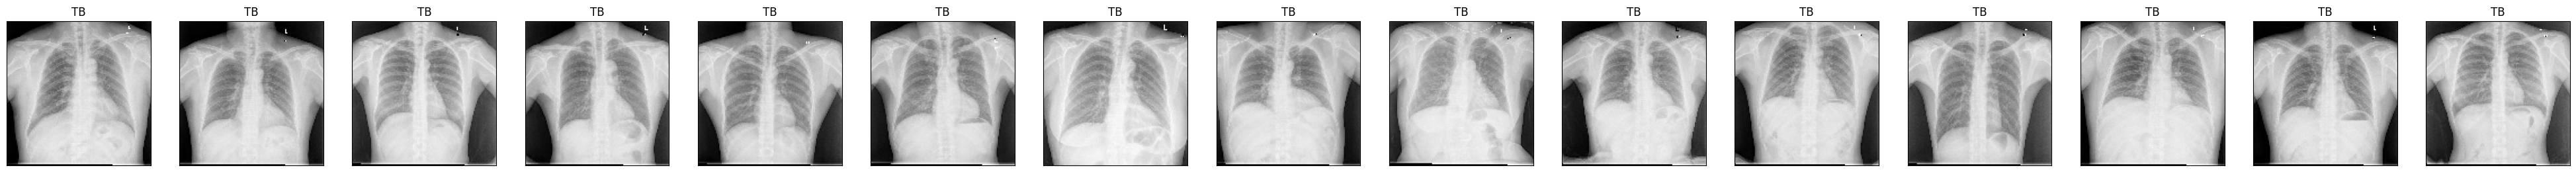

In [ ]:
plt.figure(figsize=(50, 4))
for i in range(15):
    image = np.squeeze(nn_sample_image_batch[0][i])

    plt.subplot(1, 15, i+1)
    plt.imshow(image[:,:])
    plt.yticks([])
    plt.xticks([])
    plt.title(titles[i])
plt.show()

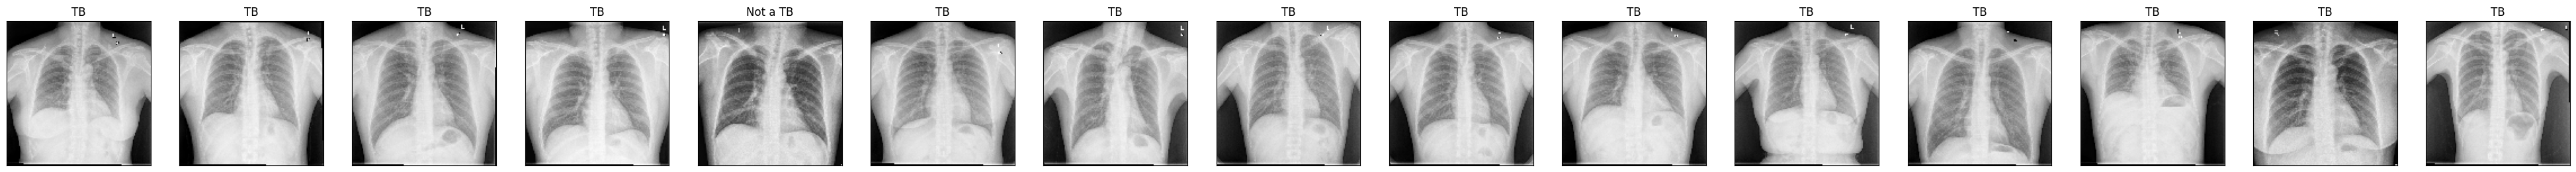

In [ ]:
plt.figure(figsize=(50, 4))
for i in range(15):
    image = np.squeeze(nn_sample_image_batch[0][i+15])

    plt.subplot(1, 15, i+1)
    plt.imshow(image[:,:], cmap='gray')
    plt.yticks([])
    plt.xticks([])
    plt.title(titles[i+15])
plt.show()